In [1]:
import pandas as pd
import json
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import seaborn as sns

from sklearn.model_selection import KFold

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('order_dict.json') as f:
    data = json.load(f)
with open('capstone_jd_msom_data-minus-click-data/warehouse_capacity.json') as f2:
    warehouse_capacity = json.load(f2)

In [3]:
order_dict = {int(k):pd.DataFrame(v).set_index('day_of_month') for k, v in data.items()}
capacity = {int(k):v[1] for k, v in warehouse_capacity.items()}

In [4]:
def preprocessing(df_i):
    
    df = df_i.copy()
    df = df.fillna(0)
    df.replace(np.inf,0, inplace = True)

    # convert data type for categorical features
    df['cluster_id'] = df['cluster_id'].astype('object')
    df['dc_ori_mode'] = df['dc_ori_mode'].astype('object')
    df['day_of_week'] = df['day_of_week'].astype('object')

    cat = ['cluster_id','dc_ori_mode','day_of_week']
    num = df.drop(cat+['demand'], axis = 1).columns
    #print(num)
    
    
    # train test split
    df_enc = pd.get_dummies(df, columns = cat, drop_first = True)
    train_enc = df_enc.query('1<= day_of_month <= 24')
    test_enc = df_enc.query('24 < day_of_month <= 31')

    # train = df.query('1<= day_of_month <= 24')
    # test = df.query('24 < day_of_month <= 31')

    # train_enc = pd.get_dummies(train, columns = cat, drop_first = True)
    # test_enc = pd.get_dummies(test, columns = cat)

    # print(train_enc.dtypes)
    # print(test_enc.dtypes)

    # standardize data
    scaler = StandardScaler()

    # x_train = train_enc[['quantity_discount_rate_mean','day_of_week_3','cluster_id_6','cluster_id_7','cluster_id_8','cluster_id_10','dc_ori_num','dc_ori_mode_7']].to_numpy()
    # x_test = test_enc[['quantity_discount_rate_mean','day_of_week_3','cluster_id_6','cluster_id_7','cluster_id_8','cluster_id_10','dc_ori_num','dc_ori_mode_7']]

    x_train = train_enc.drop(['demand', 'discount_rate_mean','type_1_percent'], axis = 1).to_numpy() # only remove highest vif column
    x_train = scaler.fit_transform(x_train)

    y_train = train_enc['demand'].to_numpy().reshape(len(train_enc), 1)


    x_test = test_enc.drop(['demand', 'discount_rate_mean','type_1_percent'], axis = 1) 
    x_test = scaler.fit_transform(x_test)

    y_test = test_enc['demand'].to_numpy().reshape(len(test_enc), 1)
    
    #print(x_train.shape, y_train.shape)
    #print(x_test.shape, y_test.shape)

    return x_train, y_train, x_test, y_test

In [5]:
def r2_loss(outputs, targets):
    target_mean = torch.mean(targets)
    ss_tot = torch.sum((targets - target_mean) ** 2)
    ss_res = torch.sum((targets - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

def r2_loss_2(outputs, targets):
    ss_tot = 0.0
    ss_res = 0.0
    target_mean = torch.mean(targets)
    for i in range(0,len(outputs)):
        ss_tot += (targets[i] - target_mean) ** 2
        ss_res += (targets[i] - outputs[i]) ** 2
    r2 = 1 - ss_res / ss_tot
    return r2

# TODO: need to work with tensor objects.
def SPOLoss (d_pred, d_actual):
    # W: items to stock the warehouse
    # h: inventory cost
    # s: shipping cost
    # ci: capacity limit for warehouse i = 1000 (per month)
    cost = 0.0
    max_capacity = capacity_i / 31
    for i in range(0, len(d_pred)):
        if d_pred[i] <= max_capacity:
            w = d_pred[i]
        else:
            w = max_capacity
        if w > d_actual[i]:
            h = 2.920 * (w - d_actual[i])  # average inventory cost per sku * (w - target)
            s = 0
        else:
            h = 0
            s = 0.803 * (d_actual[i] - w)
        cost += h + s
    return cost

def SPO_MSE_Loss(d_pred, d_actual):
    spo_loss = SPOLoss(d_pred, d_actual)
    mse_loss = 0.0
    for i in range(0, len(d_pred)):
        mse_loss += (d_pred[i] - d_actual[i]) ** 2
    mse_loss = mse_loss / len(d_pred)
    # mse_loss = sum((d_pred - d_actual) ** 2) / len(d_pred)    # don't use this, because d_pred can is 1*N dimention but d_actual can be N*1 dimension
    return spo_loss + 0.1 * mse_loss

In [6]:
# define model structure
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [7]:
# define training and evaluation functions

def predict(model, x):
    
    """
    takes in a pytorch model and a matrix of features
    return a list of predictions
    """
    
    with torch.no_grad(): # we don't need gradients in the testing phase
    # if torch.cuda.is_available():
    #     pred_y_train = model(Variable(torch.from_numpy(x_train).float().cuda())).cpu().data.numpy()
    # else:
    #     pred_y_train = model(Variable(torch.from_numpy(x_train).float())).data.numpy()
        pred_y = model(Variable(torch.from_numpy(x).float())).data.numpy()
        pred_y = [pred_y[x].item() for x in range(len(pred_y))]
    return pred_y

def linearRegressionTrain(x_train, y_train, learningRate, epochs, loss_type = 'MSE', regularize = 'None', l1_penalty = 0, l2_penalty = 0, plot = True, verbose = True):
    """
    input: 
        - x_train whose type is numpy.ndarray
        - y_train whose type is numpy.ndarray
        - learningRate
        - epochs
        - regularization can be either "None" or "l1" or "l2", default is none
        - loss_type can be either "MSE" or "SPO", default is 'MSE'
        - plot: whether you want to plot the loss against epochs, default is True
        
    output:
        trained pytorch linear regression model
    """
    _, inputDim = x_train.shape
    outputDim = 1       # takes variable 'y'
    
    loss_list = []

    model = linearRegression(inputDim, outputDim)
    
    ##### For GPU #######
    # if torch.cuda.is_available():
    #     model.cuda()
    
    # initialize the loss function and optimizer
    if loss_type == 'MSE': 
        
        criterion = torch.nn.MSELoss()  
        # criterion = r2_loss
        
        if regularize == 'None' or regularize == 'l1':
            optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
        else: # regularize = 'l2'
            optimizer = torch.optim.SGD(model.parameters(),weight_decay = l2_penalty, lr=learningRate)
            
    elif loss_type == 'SPO': # change loss function and switch to adam optimizer
        
        criterion = SPOLoss
        
        if regularize == 'None' or regularize == 'l1':
            optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
        else: # regularize = 'l2'
            optimizer = torch.optim.Adam(model.parameters(),weight_decay = l2_penalty, lr=learningRate)

    elif loss_type == 'SPO_MSE': # change loss function and switch to adam optimizer
        
        criterion = SPO_MSE_Loss
        
        if regularize == 'None' or regularize == 'l1':
            optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
        else: # regularize = 'l2'
            optimizer = torch.optim.Adam(model.parameters(),weight_decay = l2_penalty, lr=learningRate)
            
    else:
        raise Exception('wrong loss_type')
        
    # model training

    for epoch in range(epochs):
        # Converting inputs and labels to Variable
        # if torch.cuda.is_available():
        #     inputs = Variable(torch.from_numpy(x_train).cuda())
        #     labels = Variable(torch.from_numpy(y_train).cuda())
        # else:
        #     inputs = Variable(torch.from_numpy(x_train))
        #     labels = Variable(torch.from_numpy(y_train))
        inputs = Variable(torch.from_numpy(x_train))
        labels = Variable(torch.from_numpy(y_train))

        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()

        # get output from the model, given the inputs
        outputs = model(inputs.type(torch.FloatTensor))

        # get loss for the predicted output
        loss = criterion(outputs, labels.type(torch.FloatTensor))
        
        if regularize == 'l1':
            l1_norm = l1_penalty * torch.norm(model.linear.weight, p=1) # double check
            loss += l1_norm
            
        # get gradients w.r.t to parameters
        loss.backward()

        # update parameters
        optimizer.step()

        
        # break loop if percent changae in loss is less than 0.1%
        if (len(loss_list) > 300) and (abs((loss.data - loss_list[-1])/loss_list[-1]) <0.0001):
            loss_list.append(loss.data)
            break
        
        # store loss
        loss_list.append(loss.data)

        # print loss
        #if(epoch % 100 == 0):
            #print('epoch {}, loss {}'.format(epoch, loss.data))
    
    if plot:
        plt.plot(range(len(loss_list)),loss_list)
        plt.xlabel("Number of Iterations")
        plt.ylabel("Loss")
        plt.title('Gradient descend for {} loss'.format(loss_type))
        plt.show()
        
    if verbose:
        print('model trained using {} loss'.format(loss_type))
        # bias b (offset or y-intercept)
        print('y-intercept ', model.linear.bias.item())
        # weight (w)
        print('Coefficients ',  model.linear.weight.detach().numpy())
    
        pred_y_train = predict(model, x_train)
        
        print("Train MSE =",mean_squared_error(y_train,pred_y_train))
        print('Train R^2 =', r2_score(y_train, pred_y_train)) 
        print('Train SPO Loss =', SPOLoss(pred_y_train, y_train))

    return model


def generate_scores(y_true, y_pred):
    MSE = mean_squared_error(y_true, y_pred)
    R2 = r2_score(y_true, y_pred)
    SPO = SPOLoss(y_pred, y_true)
    SPO_mean = SPO / len(y_pred)
    return pd.DataFrame({'MSE': MSE, 'R^2': R2, 'SPO Loss': SPO, 'SPO Loss/day': SPO_mean})
    

def evaluation(model, x_train, x_test, y_train, y_test, plot = True):
    
    """
    this function only works for pytorch model
    
    return a 2x4 dataframe: 
        - one row for training set, the other row for testing
        - 4 columns are 4 scores: MSE, R2, SPO, SPO Ave
    """

    pred_y_train = predict(model, x_train)
    pred_y_test = predict(model, x_test)

    # Comparing Actual and predicted values
    #if plot:
        #plt.figure(figsize=(7,7))
        #plt.scatter(y_train, pred_y_train, c='b', s=10)
        #plt.xlabel('Train Actual Demand'), plt.ylabel('Train Predicted Demand');
        #lim = 100
        #x = y = range(lim)
        #plt.plot(x,y, c='brown')
        #plt.xlim(0,lim), plt.ylim(0,lim);
        #plt.show()

        #plt.figure(figsize=(7,7))
        #plt.scatter(y_test, pred_y_test, c='b', s=10)
        #plt.xlabel('Test Actual Demand'), plt.ylabel('Test Predicted Demand');
        #lim = 100
        #x = y = range(lim)
        #plt.plot(x,y, c='brown')
        #plt.xlim(0,lim), plt.ylim(0,lim);
        #plt.show()

    score_df = pd.concat([generate_scores(y_train, pred_y_train), generate_scores(y_test, pred_y_test)])
    score_df.index = ['train', 'test']
    
    return score_df

In [8]:
#import timeit
def cross_validate(x_train, y_train, loss_type, regularize, plot = True):
    # return the best penalty coefficient that minimize average validation error
    
    #start = timeit.default_timer()
    
    aveloss = dict()
    kfold = KFold(n_splits = 5)
    
    if loss_type == 'MSE':
        learningRate = 0.02
        epochs = 301
        grid = 10**-np.linspace(0,1,11) if regularize == 'l2' else 10**-np.linspace(0,5,11)
        
    elif loss_type == 'SPO':
        learningRate = 0.05
        epochs = 3001
        grid = 10**-np.linspace(-1,2,10) if regularize == 'l2' else (5,20,10)
        

    if regularize == 'l2':
        
        for i in grid:
            loss = 0
            
            for train_index, test_index in kfold.split(x_train, y_train):
                x_train_fold = x_train[train_index]
                y_train_fold = y_train[train_index]
                x_test_fold = x_train[test_index]
                y_test_fold = y_train[test_index]

                model_i = linearRegressionTrain(x_train_fold, y_train_fold, learningRate, epochs, loss_type, regularize, l2_penalty = i, plot = False, verbose = False)

                pred_y_validate = predict(model_i, x_test_fold)
                
                loss_i = generate_scores(y_test_fold, pred_y_validate)['MSE'][0] if loss_type == 'MSE' else  generate_scores(y_test_fold, pred_y_validate)['SPO Loss'][0]
                loss += loss_i
                
            aveloss[i]  = loss / 5
            #print(i)
            
    elif regularize == 'l1':
        
        for i in grid:
            loss = 0
            
            for train_index, test_index in kfold.split(x_train, y_train):
                x_train_fold = x_train[train_index]
                y_train_fold = y_train[train_index]
                x_test_fold = x_train[test_index]
                y_test_fold = y_train[test_index]

                model_i = linearRegressionTrain(x_train_fold, y_train_fold, learningRate, epochs, loss_type, regularize, l1_penalty = i, plot = False, verbose = False)

                pred_y_validate = predict(model_i, x_test_fold)
                
                loss_i = generate_scores(y_test_fold, pred_y_validate)['MSE'][0] if loss_type == 'MSE' else  generate_scores(y_test_fold, pred_y_validate)['SPO Loss'][0]
                loss += loss_i
                
            aveloss[i]  = loss / 5
    else:
        raise Exception('wrong regularization type')
        
    if plot:
        plt.plot(aveloss.keys(), aveloss.values())
        plt.xlabel('penalty coefficient')
        plt.ylabel('average {} error on validation sets'.format(loss_type))
        plt.title('Cross Validation for {} Regularization'.format(regularize))
        plt.show()
        
    best = min(aveloss, key = aveloss.get)
    #print('The best penalty coefficient is '+ str(best))
    
    #stop = timeit.default_timer()
    #print('Time: ', stop - start)  
    return best

# Model Training

In [9]:
def model_pipeline(x_train, y_train, x_test, y_test, plot_all = False):
    # MSE loss models
    learningRate = 0.02
    epochs = 501

    # ols model training
    model_ols = linearRegressionTrain(x_train, y_train, learningRate, epochs,'MSE','None', plot = plot_all, verbose = False)


    # ridge regression (l2 regrularization)
    best_l2 = cross_validate(x_train, y_train, 'MSE', 'l2', plot = plot_all)
    model_ridge = linearRegressionTrain(x_train, y_train, learningRate, epochs,'MSE','l2', l2_penalty = best_l2, plot = plot_all, verbose = False)

    # l1 regularization (lasso)
    best_l1 = cross_validate(x_train, y_train, 'MSE', 'l1', plot = plot_all)
    model_lasso = linearRegressionTrain(x_train, y_train, learningRate, epochs,'MSE', 'l1', l1_penalty = best_l1, plot = plot_all, verbose = False)

    # compile results for models trained on MSE loss
    MSE_result = []

    for model, name in zip([model_ols, model_ridge, model_lasso],['mse_ols','mse_ridge','mse_lasso']):
        score_df = evaluation(model, x_train, x_test, y_train, y_test, plot = plot_all)
        MSE_result.append(pd.concat({name:score_df}))

    MSE_scores = pd.concat([MSE_result[0], MSE_result[1],MSE_result[2]])

    # SPO loss models
    learningRate = 0.05
    epochs = 3001

    # ols model
    model_ols2 = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO','None', plot = plot_all, verbose = False)

    # ridge regression
    best_l2_spo = cross_validate(x_train, y_train, 'SPO', 'l2', plot = plot_all)
    #print('best l2 for spo loss: ', str(best_l2_spo))
    model_ridge2 = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO','l2', l2_penalty = best_l2_spo, plot = plot_all, verbose = False)
    #model_ridge2 = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO','l2', l2_penalty = 2.3357, plot = plot_all, verbose = False)

    # lasso regression
    best_l1_spo = cross_validate(x_train, y_train, 'SPO', 'l1', plot = plot_all)
    #print('best l1 for spo loss: ', str(best_l1_spo))
    model_lasso2 = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO', 'l1', l1_penalty = best_l1_spo, plot = plot_all, verbose = False)
    #model_lasso2 = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO', 'l1', l1_penalty = 10, plot = plot_all, verbose = False)

    # compile results for models trained on SPO loss
    SPO_result = []

    for model, name in zip([model_ols2, model_ridge2, model_lasso2],['spo_ols','spo_ridge','spo_lasso']):
        score_df = evaluation(model, x_train, x_test, y_train, y_test, plot = plot_all)
        SPO_result.append(pd.concat({name:score_df}))

    SPO_scores = pd.concat([SPO_result[0], SPO_result[1], SPO_result[2]])

    return MSE_scores, SPO_scores

In [10]:
%%script echo skipping

# check individual result with plot
i = 2
x_train, y_train, x_test, y_test = preprocessing(order_dict[i])
capacity_i = capacity[i]
MSE_score, SPO_score = model_pipeline(x_train, y_train, x_test, y_test, plot_all = True)
MSE_score, SPO_score

skipping


In [11]:
#MSE_score

In [12]:
#SPO_score

In [13]:
improved_results = dict()
for dc_i in [3, 6, 10, 11, 15, 16, 17, 26, 33, 34, 42, 43, 47, 49, 53, 64, 67]:
    x_train, y_train, x_test, y_test = preprocessing(order_dict[dc_i])  
    capacity_i = capacity[dc_i]
    MSE_i, SPO_i = model_pipeline(x_train, y_train, x_test, y_test)
    improved_results[dc_i] = {'MSE result': MSE_i, 'SPO result': SPO_i}
    print(str(dc_i)+' done.')

3 done.
6 done.
10 done.
11 done.
15 done.
16 done.
17 done.
26 done.
33 done.
34 done.
42 done.
43 done.
47 done.
49 done.
53 done.
64 done.
67 done.


In [14]:
#final_results.values()

In [15]:
%%script echo skipping


improved_results = {int(k): {k2: {k3: {'_'.join(k4):v4 for k4, v4 in v3.items()} 
                                     for k3, v3 in v2.items()} 
                                for k2, v2 in v.items()}  
                       for k, v in improved_results.items()}

with open('improved_results_capacity.json','w') as f:
    json.dump(improved_results, f)

In [31]:
with open('final_results_capacity.json') as f:
    data = json.load(f)

In [33]:
data

{'1': {'MSE result': {'MSE': {'mse_ols_train': 58.54527640388462,
    'mse_ols_test': 63.17856786268367,
    'mse_ridge_train': 60.95284077957098,
    'mse_ridge_test': 60.30802874942305,
    'mse_lasso_train': 61.48147897839667,
    'mse_lasso_test': 58.13605327856024},
   'R^2': {'mse_ols_train': 0.76169429209218,
    'mse_ols_test': 0.609756753854845,
    'mse_ridge_train': 0.7518944180780313,
    'mse_ridge_test': 0.6274875847305968,
    'mse_lasso_train': 0.7497426219309058,
    'mse_lasso_test': 0.6409035070436727},
   'SPO Loss': {'mse_ols_train': 2062.0559713498947,
    'mse_ols_test': 624.8078756745977,
    'mse_ridge_train': 1933.0046854664274,
    'mse_ridge_test': 568.2640441307858,
    'mse_lasso_train': 2062.7911077998087,
    'mse_lasso_test': 579.3339735332747},
   'SPO Loss/day': {'mse_ols_train': 10.41442409772674,
    'mse_ols_test': 10.961541678501714,
    'mse_ridge_train': 9.762649926598119,
    'mse_ridge_test': 9.969544633873435,
    'mse_lasso_train': 10.418136

In [25]:
pd.DataFrame(improved_results[3]['MSE result'])

,MSE,R^2,SPO Loss,SPO Loss/day
mse_ols_train,44.005101,0.769783,1709.691289,8.904642
mse_ols_test,223.528277,0.585104,504.896700,8.557571
mse_ridge_train,45.103488,0.764036,1556.362850,8.106057
mse_ridge_test,244.194760,0.546745,513.362143,8.701053
mse_lasso_train,50.445323,0.736090,1807.506893,9.414098
mse_lasso_test,248.148560,0.539406,545.135754,9.239589


In [27]:
improved_results_df = {int(k): {k2: pd.DataFrame(v2) for k2, v2 in v.items()} for k, v in improved_results.items()}

In [34]:
final_results = {int(k): {k2: pd.DataFrame(v2) for k2, v2 in v.items()} for k, v in data.items()}

In [ ]:
combined_results = improved_results_df.copy()
for k in final_results.keys():
    if k not in improved_results_df:
        combined_results[k] = final_results[k]

In [48]:
def generate_overall_result(result_dict):
    i = list(result_dict.keys())[0]
    MSE_columns, MSE_index = result_dict[i]['MSE result'].columns, result_dict[3]['MSE result'].index
    SPO_columns, SPO_index = result_dict[i]['SPO result'].columns, result_dict[3]['SPO result'].index
    mse_ave = sum([results['MSE result'].to_numpy() for results in result_dict.values()])/len(result_dict)

    mse_df = pd.DataFrame(mse_ave, columns = MSE_columns, index = MSE_index)
    
    spo_ave = sum([results['SPO result'].to_numpy() for results in improved_results_df.values()])/len(result_dict)

    spo_df = pd.DataFrame(spo_ave, columns = SPO_columns, index = SPO_index)
    
    spo_loss_ave = {dc: results['SPO result'].iloc[[1,3,5],[3]].min()[0] for dc, results in result_dict.items()}
    mse_loss_ave = {dc: results['MSE result'].iloc[[1,3,5],[3]].min()[0] for dc, results in result_dict.items()}

    plt.plot(pd.Series(spo_loss_ave), color = 'red', label = 'trained using SPO loss')
    plt.plot(pd.Series(mse_loss_ave), label = 'trained using MSE loss')
    plt.ylabel('SPO loss')
    plt.xlabel('distribution centers')
    plt.legend(loc = 'upper right')
    plt.title('SPO loss across all distribution centers')
    plt.show()
    
    cost_saved_percent = (1- pd.Series(spo_loss_ave) / pd.Series(mse_loss_ave))*100
    plt.plot(cost_saved_percent)
    plt.ylabel('cost saving percentage')
    plt.xlabel('distribution centers')
    plt.title('cost saved across all distribution centers')
    plt.plot(np.repeat(0,70))
    plt.show()
    
    return mse_df, spo_df, cost_saved_percent

In [59]:
combined_results = dict(sorted(combined_results.items()))

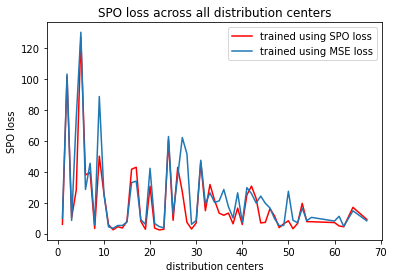

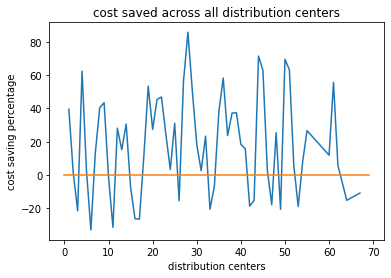

In [60]:
ave_mse, ave_spo, cost_saved_percent = generate_overall_result(combined_results)

In [61]:
ave_mse

,MSE,R^2,SPO Loss,SPO Loss/day
mse_ols_train,1522.822884,0.686822,6017.763653,27.040371
mse_ols_test,1842.235466,0.532305,1673.132485,26.332137
mse_ridge_train,1606.418498,0.672043,5513.827654,24.725164
mse_ridge_test,1843.605543,0.546514,1533.279778,24.098840
mse_lasso_train,1543.945502,0.667805,5971.418886,26.837277
mse_lasso_test,1810.232671,0.566433,1603.677018,25.195118


In [62]:
ave_spo

,MSE,R^2,SPO Loss,SPO Loss/day
spo_ols_train,277.441878,0.129697,694.216947,3.182921
spo_ols_test,682.485254,0.062483,411.001993,6.470884
spo_ridge_train,302.723399,0.106830,727.699262,3.336231
spo_ridge_test,729.615570,0.038485,423.849967,6.677125
spo_lasso_train,297.519260,0.112148,719.409657,3.299539
spo_lasso_test,712.544959,0.046390,414.612542,6.530590


In [63]:
sum(cost_saved_percent < 0)/len(cost_saved_percent)

0.2833333333333333

In [64]:
cost_saved_percent[cost_saved_percent < 0]

3    -21.443929
6    -32.957998
10    -1.263364
11   -31.380756
15    -7.240512
16   -26.202485
17   -26.519397
26   -15.443382
33   -20.537583
34    -6.620968
42   -18.674143
43   -15.170225
47   -17.791227
49   -20.563193
53   -18.874997
64   -15.166827
67   -10.814777
dtype: float64

Ref:
Lineary Regression with Pytorch
  
  https://medium.com/analytics-vidhya/linear-regression-with-pytorch-147fed55f138
  
  https://linuxhint.com/pytorch_linear_regression_tutorial/
  
  https://medium.com/biaslyai/pytorch-linear-and-logistic-regression-models-5c5f0da2cb9
  
  https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817
  
  https://www.reneshbedre.com/blog/pytorch-regression.html
  
  https://www.kaggle.com/joseguzman/multiple-regression-explained-with-pytorch?scriptVersionId=73005237
  
  https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_linear_regression/#building-a-linear-regression-model-with-pytorch-gpu
  
Evaluations:

  https://www.analyticsvidhya.com/blog/2021/05/know-the-best-evaluation-metrics-for-your-regression-model/
  
Quick Ordinary Lineary Regression Calculator:

  https://www.socscistatistics.com/tests/regression/default.aspx
